# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDR clusters

## 1.1 - Load in IDR information

In [3]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in IDR z-score data

In [4]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

90
(24508, 90)


## 1.3 - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length and min inter cluster distance gte 1.5

In [5]:
minidrlength=50
minidrlinkerlength=70
mininterclustdist=1.5

subidrsdf=humandf[humandf['IDR Length']>=minidrlength]
subidrsdf=subidrsdf[ (subidrsdf['IDR Length']>=minidrlinkerlength) | (subidrsdf['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
subidrsdf=subidrsdf[subidrsdf['Min Inter Clust Dist']>=mininterclustdist]
print(subidrsdf.isnull().any())
subidrsdf = subidrsdf.fillna('')
print(subidrsdf)

subaccs=subidrsdf['Uniprot'].tolist()
subaccswnums=subidrsdf['Uniprot w IDRnum'].tolist()
subgeneswnums=subidrsdf['Gene'].tolist()
subclusters=subidrsdf['Cluster Number'].tolist()
subseqlens=subidrsdf['IDR Length'].tolist()
substpos=subidrsdf['Start Pos'].tolist()
subenpos=subidrsdf['End Pos'].tolist()
subproteinlength=subidrsdf['Full Protein Length'].tolist()
submininterclustdist=subidrsdf['Min Inter Clust Dist'].tolist()
subtermini=subidrsdf['IDR Position'].tolist()
subseqs=subidrsdf['Sequence'].tolist()
sublocstring=subidrsdf['HPA Location'].tolist()


sublocationbyunistring=sublocstring


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24495       24495  Q6ZSZ5         Q6ZSZ5_1   ARHGEF1

## 1.3b - Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length - used when don't care about cluster distance

In [6]:
subidrsdfNODIST=humandf[humandf['IDR Length']>=minidrlength]
subidrsdfNODIST=subidrsdfNODIST[ (subidrsdfNODIST['IDR Length']>=minidrlinkerlength) | (subidrsdfNODIST['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
print(subidrsdfNODIST.isnull().any())
subidrsdfNODIST = subidrsdfNODIST.fillna('')
print(subidrsdfNODIST)

subaccsNODIST=subidrsdfNODIST['Uniprot'].tolist()
subaccswnumsNODIST=subidrsdfNODIST['Uniprot w IDRnum'].tolist()
subgeneswnumsNODIST=subidrsdfNODIST['Gene'].tolist()
subclustersNODIST=subidrsdfNODIST['Cluster Number'].tolist()
subseqlensNODIST=subidrsdfNODIST['IDR Length'].tolist()
substposNODIST=subidrsdfNODIST['Start Pos'].tolist()
subenposNODIST=subidrsdfNODIST['End Pos'].tolist()
subproteinlengthNODIST=subidrsdfNODIST['Full Protein Length'].tolist()
submininterclustdistNODIST=subidrsdfNODIST['Min Inter Clust Dist'].tolist()
subterminiNODIST=subidrsdfNODIST['IDR Position'].tolist()
subseqsNODIST=subidrsdfNODIST['Sequence'].tolist()
sublocstringNODIST=subidrsdfNODIST['HPA Location'].tolist()


sublocationbyunistringNODIST=sublocstringNODIST

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

# Part 2: Get subcellular location information

## 2.1 - Load in subcellular information from HPA

In [8]:
HPAtable=pd.read_table('../general_data/HPA/subcellular_location.tsv')

print(HPAtable)

tmp=HPAtable[HPAtable['Gene name']=='POLR2A']
print(tmp)

tmp=HPAtable[HPAtable['Gene name']=='ZRSR2']
print(tmp)

                  Gene        Gene name Reliability            Main location  \
0      ENSG00000000003           TSPAN6    Approved   Cell Junctions;Cytosol   
1      ENSG00000000457            SCYL3   Supported  Cytosol;Golgi apparatus   
2      ENSG00000000460         C1orf112    Approved             Mitochondria   
3      ENSG00000000938              FGR    Approved          Plasma membrane   
4      ENSG00000000971              CFH    Approved                 Vesicles   
...                ...              ...         ...                      ...   
13142  ENSG00000290292            HOMEZ   Supported                 Nucleoli   
13143  ENSG00000290315  ENSG00000290315    Approved      Cytosol;Nucleoplasm   
13144  ENSG00000290317  ENSG00000290317    Approved              Nucleoplasm   
13145  ENSG00000291237             SOD2   Supported             Mitochondria   
13146  ENSG00000291316  ENSG00000291316    Approved              Nucleoplasm   

             Additional location    Ext

## 2.2 - Get all unique locations

In [9]:
allloc=HPAtable['Main location'].tolist()
allens=HPAtable['Gene'].tolist()

uniqueloc=[]
for a in allloc:
    if isinstance(a,str):
        #print(a)
        tmp=a.split(';')
        #print(tmp)
        for i in tmp:
            if i not in uniqueloc:
                uniqueloc.append(i)

uniqueloc.sort(key=str.lower)            
print(uniqueloc)
print(len(uniqueloc))

['Actin filaments', 'Aggresome', 'Cell Junctions', 'Centriolar satellite', 'Centrosome', 'Cytokinetic bridge', 'Cytoplasmic bodies', 'Cytosol', 'Endoplasmic reticulum', 'Endosomes', 'Focal adhesion sites', 'Golgi apparatus', 'Intermediate filaments', 'Kinetochore', 'Lipid droplets', 'Lysosomes', 'Microtubule ends', 'Microtubules', 'Midbody', 'Midbody ring', 'Mitochondria', 'Mitotic chromosome', 'Mitotic spindle', 'Nuclear bodies', 'Nuclear membrane', 'Nuclear speckles', 'Nucleoli', 'Nucleoli fibrillar center', 'Nucleoli rim', 'Nucleoplasm', 'Peroxisomes', 'Plasma membrane', 'Rods & Rings', 'Vesicles']
34


## 2.3 - Get accession for each location

In [10]:
# Load in mapping of accessions to ensemble
ens2uni=pd.read_table('../general_data/HPA/ENSEMBL_to_Uniprot_location_proteins_202312_no_duplicates.tsv')

unimap=ens2uni['Uniprot'].tolist()
ensmap=ens2uni['ENSEMBL'].tolist()
# mapping is bad for POLR2A so add it 
unimap.append('P24928')
ensmap.append('ENSG00000181222')

uniquelocacc=[[] for x in range(len(uniqueloc))]
mappedaccs=[]
count=0
for f in range(0,len(subaccs)):
    if subaccs[f] in unimap:
        idx=unimap.index(subaccs[f])
        if ensmap[idx] in allens:
            # Gets all accessions that can be mapped to HPA
            count=count+1
            mappedaccs.append(subaccs[f])
            
            # find index of ensembl accession in hpa data
            idx2=allens.index(ensmap[idx])
            
            for a in range(0,len(uniqueloc)):
                if uniqueloc[a] in allloc[idx2]:
                    if subaccs[f] not in uniquelocacc[a]:
                        uniquelocacc[a].append(subaccs[f])
                        #print(mygenes[f])
                        #print(subaccs[f])
                        #print(allloc[idx2])
                        #print(idx)
                        #hi

print(len(subaccs))
print('Number of mapped accessions '+str(count))
#print(uniquelocacc)

8560
Number of mapped accessions 6619


# Part 3: Plot IDRs in cluster and location

## 3.1 - For a given cluster and location plot sorted top feature

        Genes    Z-score      NCPR    Abundance Marker Uniprot  \
7     RBM25-4  -0.604916 -0.030172    89.307523      o  P49756   
23   HP1BP3-1   0.509703 -0.061069   281.218943      o  Q5SSJ5   
22     RBM6-5   1.570439 -0.069444     7.436634      o  P78332   
15       IK-1   1.821810 -0.014085   161.976362      o  Q13123   
13    CWC15-1   1.916240 -0.061798   510.309868      o  Q9P013   
16   BCLAF1-5   2.237359  0.050000    47.074692      o  Q9NYF8   
10    NCBP3-2   2.303676 -0.189189     5.038344      o  Q53F19   
4    CDK11A-1   3.439419 -0.100000    12.419889      o  Q9UQ88   
6    CDK11B-1   3.593197 -0.086747    12.419889      o  P21127   
5    AKAP8L-1   3.936280 -0.040984    42.565117      o  Q9ULX6   
12    RBM8A-1   4.084014 -0.114286  1736.865177      o  Q9Y5S9   
14     EAPP-1   4.421678 -0.091429    19.633557      o  Q56P03   
8     DDX42-1   4.430232 -0.088050    48.066167      o  Q86XP3   
18     CHD5-5   4.668026 -0.088608     1.536109      o  Q8TDI0   
20    SART

(-1.6049156882413451, 11.371957889081825)

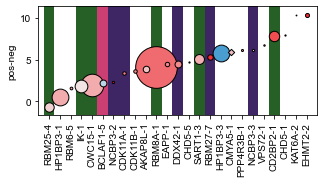

In [39]:
#myclust=7
#myloc='Nucleoli'
#tmpfeats=['neg-neg']

#myclust=18
#myloc='Nucleoli'
#tmpfeats=['pos-neg']

#myclust=23
#myloc='Nucleoli'
#tmpfeats=['pos-pos']

# Load in ribosome biogenesis info if examining nucleoli clusters
#dfcompclust=pd.read_excel('data/Ribosomal_biogeneis_factors.xlsx', sheet_name='All_biogenesis_factors')
#proccolor={'rDNA Transcription':'#ff6361', 'rRNA Modification':'#872f74', 'Factors involved in pre‐rRNA processing':'#3d2663', 'Chaperones of ribosomal proteins':'#cb3f73', \
#           'SSU processome subcomplexes and early assembly factors':'#276026','Factors involved in nucleolar steps of 60S maturation':'#008770', 'Other factors involved in ribosome biogenesis':'#00aabe'}


myclust=18
myloc='Nuclear speckles'
tmpfeats=['pos-neg']

# Load in spliceosome info if examining nuclear speckles clusters
dfcompclust=pd.read_excel('data/Nuclear_speckles_complexes_w_clusters_IDRs_gte_70_and_nonlinkers_gte_50.xlsx')
proccolor={'Major Spliceosome':'#276026', 'Splicing factors':'#3d2663', 'RNA Modification':'#cb3f73', 'Minor Spliceosome':'#872f74', 'ASAP complex':'#ff6361'}


midx = [i for i, x in enumerate(subclusters) if x == myclust]

topaccs=[]
for i in midx:
    topaccs.append(subaccswnums[i])
    

pos=uniqueloc.index(myloc)
idx1=myfeat.index(tmpfeats[0])

# Load in abundance information
abundf=pd.read_excel('../general_data/HeLa_Proteome.xlsx',sheet_name='Sheet1')
alist=abundf['fmol protein'].tolist()
u2list=abundf['Uniprot'].tolist()
g2list=abundf['Gene name'].tolist()

rbproc=list(proccolor.keys())
rbprocaccs=[]
for i in range(0,len(rbproc)):
    dftmp=dfcompclust[dfcompclust['General Process']==rbproc[i]]
    rbprocaccs.append(dftmp['Accession'].tolist())

# Create z-score vector of subset
suballidx=[]
for s in range(0,len(subaccswnums)):
    suballidx.append(fullaccswnums.index(subaccswnums[s]))
    
subzvecaa=fullzvec[suballidx,:]


tmpfeat=[]
tmpgenes=[]
tmpncpr=[]
tmpabund=[]
tmpmarkerlist=[]
tmpaccloc=[]
tmpacc=[]
for s in range(0,len(subaccs)):
    if subaccs[s] in mappedaccs:
        if subaccs[s] in uniquelocacc[pos]:
            if subaccswnums[s] in topaccs:
                #print(subgeneswnums[s])
                #print(subaccs[s])
                tmpaccloc.append(subaccs[s])
                
                tmp=subgeneswnums[s].split(' ')
                tmpfeat.append(subzvecaa[s,idx1])
                tmpgenes.append(tmp[0]+'-'+tmp[1][3:])
                tmpacc.append(subaccs[s])

                SeqOb=SequenceParameters(subseqs[s])
                tmpncpr.append(SeqOb.get_NCPR())
                
                tmpidx=[i for i, ltr in enumerate(u2list) if subaccs[s] in ltr]
                if tmpidx:
                    tmpabund.append(alist[tmpidx[0]])
                    tmpmarkerlist.append('o')
                
                else:
                    tmpabund.append(20)
                    tmpmarkerlist.append('D')
                
tmpdf=pd.DataFrame()
tmpdf['Genes']=tmpgenes
tmpdf['Z-score']=tmpfeat
tmpdf['NCPR']=tmpncpr
tmpdf['Abundance']=tmpabund
tmpdf['Marker']=tmpmarkerlist
tmpdf['Uniprot']=tmpacc

tmpdf = tmpdf.sort_values(by=['Z-score'])
stmpfeat=tmpdf['Z-score'].tolist()
stmpgenes=tmpdf['Genes'].tolist()
stmpncpr=tmpdf['NCPR'].tolist()
stmpabund=tmpdf['Abundance'].tolist()
stmpmarkerlist=tmpdf['Marker'].tolist()
stmpacc=tmpdf['Uniprot'].tolist()

stmpproc=[]
for i in range(0,len(stmpacc)):
    currproclist=[]
    for p in range(0,len(rbproc)):
        if stmpacc[i] in rbprocaccs[p]:
            currproclist.append(rbproc[p])
    if len(currproclist)>1:
        currproc=', '.join(currproclist)
    elif len(currproclist)==1:
        currproc=currproclist[0]
    else:
        currproc=''
    stmpproc.append(currproc)
        
tmpdf['Process']=stmpproc
print(tmpdf)

fig, ax = plt.subplots()
fig.set_size_inches(len(stmpgenes)/5,2)
mybwr=sbn.diverging_palette(12, 246, s=99, l=50, sep=5, n=6, center='light', as_cmap=True)
limval=1

tmp = np.argsort(stmpabund)
sort_index2 = tmp[::-1] 
for i in sort_index2:
    plt.scatter(i,stmpfeat[i], s=stmpabund[i], vmin=-0.2, vmax=0.2, cmap=mybwr, c=stmpncpr[i], marker=stmpmarkerlist[i], edgecolors='k',zorder=10)
    for p in range(0,len(rbproc)):
        if stmpacc[i] in rbprocaccs[p]:
            ax.add_patch(Rectangle((i-0.5, min(stmpfeat)-limval), 1, max(stmpfeat)-min(stmpfeat)+2*limval, facecolor=proccolor[rbproc[p]], alpha=1))
            
    
#for i in range(0,len(stmpfeat)):
#    plt.scatter(i,stmpfeat[i], s=stmpabund[i], vmin=-0.2, vmax=0.2, cmap=mybwr, c=stmpncpr[i], marker=stmpmarkerlist[i], edgecolors='k')


#plt.bar(np.arange(0,len(stmpfeat),1),stmpfeat)
plt.xticks(np.arange(0, len(stmpgenes), 1), stmpgenes,rotation=90) 
plt.ylabel(tmpfeats[0])
plt.xlim([-1, len(stmpgenes)])
plt.ylim([min(stmpfeat)-limval, max(stmpfeat)+limval])


#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'.pdf', transparent=True, bbox_inches = "tight") 
#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'_figsize_by_num_IDR.pdf', transparent=True, bbox_inches = "tight") 
#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'_figsize_by_num_IDR_w_process.pdf', transparent=True, bbox_inches = "tight") 

    
#fig, ax = plt.subplots()
#fig.set_size_inches(len(stmpgenes)/5,2)
#radii=[10,100,1000]
#for r in range(0,len(radii)):
#    plt.scatter(r,10, s=radii[r], color='#d7d7d7', marker='o', edgecolors='k',zorder=10)
#plt.xlim([-1, r+1])
#plt.savefig('Figures/2024_02/Abundance_legend_10_100_1000.pdf', transparent=True, bbox_inches = "tight") 


#with pd.ExcelWriter('../Supplementary_Tables/Table_S2.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_2A')

#with pd.ExcelWriter('../Supplementary_Tables/Table_S3.xlsx', engine='openpyxl') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_3A')

## 3.2 - For a given cluster and location plot sorted top feature - not z-score

        Genes  Cumulative Length of Q Patches      NCPR  Abundance Marker  \
56     SOX9-3                               0 -0.007246   2.732156      o   
34    MRTFA-3                               5  0.040000  19.524582      o   
37  HIVEP1-16                               6  0.000000   0.110385      o   
4    CITED2-1                               6  0.000000  20.000000      D   
69    EP400-2                               6  0.027778   1.592198      o   
..        ...                             ...       ...        ...    ...   
26    NCOA6-1                              71  0.028736   0.445791      o   
52   TRERF1-3                              71  0.000000   0.494585      o   
73    MED15-2                              89  0.011628  10.688072      o   
53    MED12-8                              94  0.031390   0.945651      o   
55   PAXIP1-2                             130  0.000000   6.851594      o   

   Uniprot                                            Process  
56  P48436 

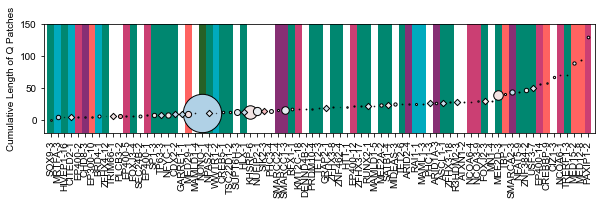

In [47]:
#myclust=26
#myloc='Nuclear speckles'
#tmpfeats=['Cumulative Length of R Patches']

## Load in spliceosome info
#dfcompclust=pd.read_excel('data/Nuclear_speckles_complexes_w_clusters_IDRs_gte_70_and_nonlinkers_gte_50.xlsx')
#proccolor={'Major Spliceosome':'#276026', 'Splicing factors':'#3d2663', 'RNA Modification':'#cb3f73', 'Minor Spliceosome':'#872f74', 'ASAP complex':'#ff6361'}

myclust=11
myloc='Nucleoplasm'
tmpfeats=['Cumulative Length of Q Patches']

# Load in nucleoplasm complexes info
dfcompclust=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='Nucleoplasm_w_Factors_Binding')
proccolor={'RNA binding':'#276026','Transcription factor':'#008770','Transcription co-factor':'#00aabe','Enhanceosomes':'#3d2663', 'Chromatin remodeling complex':'#872f74', 'Histone modifying complex':'#cb3f73', 'RNA polymerase II-mediated transcription':'#ff6361'}



numInt=2 # Number of allowable interruption residues
minBlockLen=4 # Must have at least minBlockLen lysines in the block

midx = [i for i, x in enumerate(subclusters) if x == myclust]

topaccs=[]
for i in midx:
    topaccs.append(subaccswnums[i])
    

posloc=uniqueloc.index(myloc)

# Load in abundance information
abundf=pd.read_excel('../general_data/HeLa_Proteome.xlsx',sheet_name='Sheet1')
alist=abundf['fmol protein'].tolist()
u2list=abundf['Uniprot'].tolist()
g2list=abundf['Gene name'].tolist()

rbproc=list(proccolor.keys())
rbprocaccs=[]
for i in range(0,len(rbproc)):
    dftmp=dfcompclust[dfcompclust['General Process']==rbproc[i]]
    rbprocaccs.append(dftmp['Accession'].tolist())

testaas=tmpfeats[0].split(' ')[3]
xrichlen=[[] for _ in range(len(testaas))]

tmpfeat=[]
tmpgenes=[]
tmpncpr=[]
tmpabund=[]
tmpmarkerlist=[]
tmpacc=[]
tmpseqs=[]
for s in range(0,len(subaccs)):
    if subaccs[s] in mappedaccs:
        if subaccs[s] in uniquelocacc[posloc]:
            if subaccswnums[s] in topaccs:
                #print(subgeneswnums[s])
                #print(accs_sub[s])
                
                tmp=subgeneswnums[s].split(' ')  
                tmpgenes.append(tmp[0]+'-'+tmp[1][3:])
                tmpacc.append(subaccs[s])
                tmpseqs.append(subseqs[s])

                currseq=subseqs[s]
                SeqOb=SequenceParameters(subseqs[s])
                tmpncpr.append(SeqOb.get_NCPR())
                
                tmpidx=[i for i, ltr in enumerate(u2list) if subaccs[s] in ltr]
                if tmpidx:
                    tmpabund.append(alist[tmpidx[0]])
                    tmpmarkerlist.append('o')
                
                else:
                    tmpabund.append(20)
                    tmpmarkerlist.append('D')
                    
    
                ## Fraction of sequence containing patches
                counta=-1
                for a in testaas:
                    counta=counta+1
                    justKs='0'*len(currseq) # Set string of zeros

                    pos=[i for i, ltr in enumerate(currseq) if ltr == a] # Find positions of the residue of interest

                    # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
                    pos2=pos
                    for p in range(0,len(pos)-1):
                        tdi=pos[p+1]-pos[p]
                        if tdi > 1 and tdi<=numInt+1:
                            myt=list(range(pos[p]+1,pos[p+1]))
                            for item in myt:
                                pos2.append(item)


                    # For positions make those 1 in string of zeros   
                    justKs = list(justKs)
                    for p in pos2:
                        justKs[p]='1'
                    justKs = ''.join(justKs)


                    the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
                    idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

                    numpatches=0
                    count=-1
                    patchescombined=''
                    for o in the_ones:
                        count=count+1
                        myrange=idx_ones[count] # Get indices for each consecutive strength
                        subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
                        pos3=[i for i, ltr in enumerate(subseq) if ltr == a] # Get positions of the actual residue of interest in this subseq
                        # If the number of the actual residue of interest is greater than or equal to minBlockLen add to the number of patches and string patches together in string
                        if len(pos3)>=minBlockLen:
                            numpatches=numpatches+1
                            patchescombined+=subseq
                            #print(subseq)

                    #print(patchescombined)
                    xrichlen[counta].append(len(patchescombined))
                
#print(xrichlen)


tmpdf=pd.DataFrame()
tmpdf['Genes']=tmpgenes
tmpdf[tmpfeats[0]]=xrichlen[0]
tmpdf['NCPR']=tmpncpr
tmpdf['Abundance']=tmpabund
tmpdf['Marker']=tmpmarkerlist
tmpdf['Uniprot']=tmpacc

tmpdf = tmpdf.sort_values(by=[tmpfeats[0]])
stmpfeat=tmpdf[tmpfeats[0]].tolist()
stmpgenes=tmpdf['Genes'].tolist()
stmpncpr=tmpdf['NCPR'].tolist()
stmpabund=tmpdf['Abundance'].tolist()
stmpmarkerlist=tmpdf['Marker'].tolist()
stmpacc=tmpdf['Uniprot'].tolist()

stmpproc=[]
for i in range(0,len(stmpacc)):
    currproclist=[]
    for p in range(0,len(rbproc)):
        if stmpacc[i] in rbprocaccs[p]:
            currproclist.append(rbproc[p])
    if len(currproclist)>1:
        currproc=', '.join(currproclist)
    elif len(currproclist)==1:
        currproc=currproclist[0]
    else:
        currproc=''
    stmpproc.append(currproc)
        
tmpdf['Process']=stmpproc
print(tmpdf)


fig, ax = plt.subplots()
#fig.set_size_inches(len(stmpgenes)/5,2) # for speckles
fig.set_size_inches(len(stmpgenes)/8,2) # for nucleoplasm
mybwr=sbn.diverging_palette(12, 246, s=99, l=50, sep=5, n=6, center='light', as_cmap=True)
limval=20
print(min(stmpfeat))
print(max(stmpfeat))

tmp = np.argsort(stmpabund)
sort_index2 = tmp[::-1] 
for i in sort_index2:
    plt.scatter(i,stmpfeat[i], s=stmpabund[i], vmin=-0.2, vmax=0.2, cmap=mybwr, c=stmpncpr[i], marker=stmpmarkerlist[i], edgecolors='k',zorder=10)
    for p in range(0,len(rbproc)):
        if stmpacc[i] in rbprocaccs[p]:
            ax.add_patch(Rectangle((i-0.5, min(stmpfeat)-limval), 1, max(stmpfeat)-min(stmpfeat)+2*limval, facecolor=proccolor[rbproc[p]], alpha=1))

#for i in range(0,len(stmpfeat)):
#    plt.scatter(i,stmpfeat[i], s=stmpabund[i], vmin=-0.2, vmax=0.2, cmap=mybwr, c=stmpncpr[i], marker=stmpmarkerlist[i], edgecolors='k')


#plt.bar(np.arange(0,len(stmpfeat),1),stmpfeat)
plt.xticks(np.arange(0, len(stmpgenes), 1), stmpgenes,rotation=90) 
plt.ylabel(tmpfeats[0])
plt.xlim([-1, len(stmpgenes)])
plt.ylim([min(stmpfeat)-limval, max(stmpfeat)+limval])

#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'.pdf', transparent=True, bbox_inches = "tight") 
#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'_figsize_by_num_IDR.pdf', transparent=True, bbox_inches = "tight") 
#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'_figsize_by_num_IDR_w_process.pdf', transparent=True, bbox_inches = "tight") 

#with pd.ExcelWriter('../Supplementary_Tables/Table_S3.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_3B')

#with pd.ExcelWriter('../Supplementary_Tables/Table_S5.xlsx', engine='openpyxl') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_5B')

## 3.3 - For a given cluster and location plot sorted top feature - number of aas

M
         Genes  Number M      NCPR  Abundance Marker Uniprot  \
65    QRICH2-3       0.0 -0.058140  20.000000      D  Q9H0J4   
109    MAST4-2       0.0  0.082353   0.019792      o  O15021   
17     SOX30-3       0.0  0.022472  20.000000      D  O94993   
51   PLEKHG2-6       0.0 -0.068182   1.434293      o  Q9H7P9   
82      HROB-1       0.0  0.085106  20.000000      D  Q8N3J3   
..         ...       ...       ...        ...    ...     ...   
12     SSBP3-1      23.0 -0.003425  20.000000      D  Q9BWW4   
21    EP300-11      24.0  0.003106   2.149677      o  Q09472   
5     ARID1B-2      33.0  0.009785   2.608752      o  Q8NFD5   
6     ARID1B-4      34.0  0.015086   2.608752      o  Q8NFD5   
97     BCL9L-5      37.0  0.012448   1.674360      o  Q86UU0   

                                      Process  
65                                             
109                                            
17                       Transcription factor  
51                                   

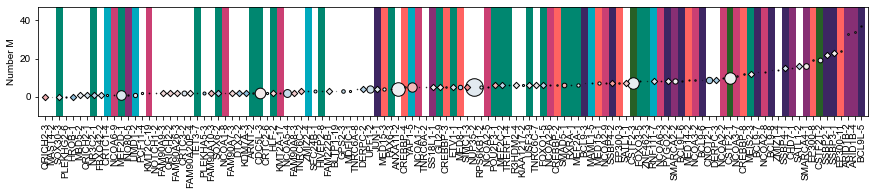

In [52]:
myclust=10
myloc='Nucleoplasm'
tmpfeats=['Number M']

#myclust=28
#myloc='Nucleoplasm'
#tmpfeats=['Number Y']


midx = [i for i, x in enumerate(subclusters) if x == myclust]

topaccs=[]
for i in midx:
    topaccs.append(subaccswnums[i])
    
pos=uniqueloc.index(myloc)

testaas=tmpfeats[0].split(' ')[1]
print(testaas)

# Load in abundance information
abundf=pd.read_excel('../general_data/HeLa_Proteome.xlsx',sheet_name='Sheet1')
alist=abundf['fmol protein'].tolist()
u2list=abundf['Uniprot'].tolist()
g2list=abundf['Gene name'].tolist()

# Load in nucleoplasm complexes info
dfcompclust=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='Nucleoplasm_w_Factors_Binding')
proccolor={'RNA binding':'#276026','Transcription factor':'#008770','Transcription co-factor':'#00aabe','Enhanceosomes':'#3d2663', 'Chromatin remodeling complex':'#872f74', 'Histone modifying complex':'#cb3f73', 'RNA polymerase II-mediated transcription':'#ff6361'}

rbproc=list(proccolor.keys())
rbprocaccs=[]
for i in range(0,len(rbproc)):
    dftmp=dfcompclust[dfcompclust['General Process']==rbproc[i]]
    rbprocaccs.append(dftmp['Accession'].tolist())

suballidx=[]
for s in range(0,len(subaccswnums)):
    suballidx.append(fullaccswnums.index(subaccswnums[s]))


tmpfeat=[]
tmpgenes=[]
tmpncpr=[]
tmpabund=[]
tmpmarkerlist=[]
tmpaccloc=[]
tmpacc=[]
for s in range(0,len(subaccs)):
    if subaccs[s] in mappedaccs:
        if subaccs[s] in uniquelocacc[pos]:
            if subaccswnums[s] in topaccs:
                #print(subgeneswnums[s])
                #print(subaccs[s])
                tmpaccloc.append(subaccs[s])

                SeqOb=SequenceParameters(subseqs[s])
                aafrac=SeqOb.get_amino_acid_fractions()
                slen=SeqOb.get_length()
                tmpncpr.append(SeqOb.get_NCPR())
                
                tmp=subgeneswnums[s].split(' ')
                tmpfeat.append(aafrac[testaas]*slen)
                tmpgenes.append(tmp[0]+'-'+tmp[1][3:])
                tmpacc.append(subaccs[s])
                
                tmpidx=[i for i, ltr in enumerate(u2list) if subaccs[s] in ltr]
                if tmpidx:
                    tmpabund.append(alist[tmpidx[0]])
                    tmpmarkerlist.append('o')
                
                else:
                    tmpabund.append(20)
                    tmpmarkerlist.append('D')
                
tmpdf=pd.DataFrame()
tmpdf['Genes']=tmpgenes
tmpdf[tmpfeats[0]]=tmpfeat
tmpdf['NCPR']=tmpncpr
tmpdf['Abundance']=tmpabund
tmpdf['Marker']=tmpmarkerlist
tmpdf['Uniprot']=tmpacc

tmpdf = tmpdf.sort_values(by=[tmpfeats[0]])
stmpfeat=tmpdf[tmpfeats[0]].tolist()
stmpgenes=tmpdf['Genes'].tolist()
stmpncpr=tmpdf['NCPR'].tolist()
stmpabund=tmpdf['Abundance'].tolist()
stmpmarkerlist=tmpdf['Marker'].tolist()
stmpacc=tmpdf['Uniprot'].tolist()

stmpproc=[]
for i in range(0,len(stmpacc)):
    currproclist=[]
    for p in range(0,len(rbproc)):
        if stmpacc[i] in rbprocaccs[p]:
            currproclist.append(rbproc[p])
    if len(currproclist)>1:
        currproc=', '.join(currproclist)
    elif len(currproclist)==1:
        currproc=currproclist[0]
    else:
        currproc=''
    stmpproc.append(currproc)
        
tmpdf['Process']=stmpproc
print(tmpdf)

fig, ax = plt.subplots()
fig.set_size_inches(len(stmpgenes)/8,2)
mybwr=sbn.diverging_palette(12, 246, s=99, l=50, sep=5, n=6, center='light', as_cmap=True)
limval=10

tmp = np.argsort(stmpabund)
sort_index2 = tmp[::-1] 
for i in sort_index2:
    plt.scatter(i,stmpfeat[i], s=stmpabund[i], vmin=-0.2, vmax=0.2, cmap=mybwr, c=stmpncpr[i], marker=stmpmarkerlist[i], edgecolors='k',zorder=10)
    for p in range(0,len(rbproc)):
        if stmpacc[i] in rbprocaccs[p]:
            ax.add_patch(Rectangle((i-0.5, min(stmpfeat)-limval), 1, max(stmpfeat)-min(stmpfeat)+2*limval, facecolor=proccolor[rbproc[p]], alpha=1))

#for i in range(0,len(stmpfeat)):
#    plt.scatter(i,stmpfeat[i], s=stmpabund[i], vmin=-0.2, vmax=0.2, cmap=mybwr, c=stmpncpr[i], marker=stmpmarkerlist[i], edgecolors='k')


#plt.bar(np.arange(0,len(stmpfeat),1),stmpfeat)
plt.xticks(np.arange(0, len(stmpgenes), 1), stmpgenes,rotation=90) 
plt.ylabel(tmpfeats[0])
plt.xlim([-1, len(stmpgenes)])
plt.ylim([min(stmpfeat)-limval, max(stmpfeat)+limval])

#plt.savefig('Figures/2024_02/location_cluster_feature_sorted/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_dist_gte_'+str(mininterclustdist)+'_cluster_'+str(myclust)+'_location_'+str(myloc)+'_feature_'+tmpfeats[0]+'.pdf', transparent=True, bbox_inches = "tight") 


#with pd.ExcelWriter('../Supplementary_Tables/Table_S5.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='Fig_5A')

# Part 4: Get data for SanKey plots

## 4.1 - Analyze at nucleolar complexes

In [54]:
rbdf=pd.read_excel('data/Ribosomal_biogeneis_factors.xlsx',sheet_name='All_biogenesis_factors')
print(rbdf)

rbaccs=rbdf['Accession'].tolist()

rbhasIDR=[]
rbclustertypes=[]
rb7=[]
rb18=[]
rb23=[]
rb71823=[]
for s in range(0,len(rbaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == rbaccs[s]]
    if not pos:
        rbhasIDR.append('No')
        rb7.append('No')
        rb18.append('No')
        rb23.append('No')
        rb71823.append('No')
    else:
        rbhasIDR.append('Yes')
        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        if 7 in tmplist:
            rb7.append('Yes')
        else:
            rb7.append('No')
            
        if 18 in tmplist:
            rb18.append('Yes')
        else:
            rb18.append('No')
                        
        if 23 in tmplist:
            rb23.append('Yes')
        else:
            rb23.append('No')
            
        if 7 in tmplist or 18 in tmplist or 23 in tmplist:
            rb71823.append('Yes')
        else:
            rb71823.append('No')

rbdfwclust=rbdf
rbdfwclust['IDR']=rbhasIDR
rbdfwclust['Cluster 7']=rb7
rbdfwclust['Cluster 18']=rb18
rbdfwclust['Cluster 23']=rb23
rbdfwclust['Cluster 7, 18, or 23']=rb71823

print(rbdfwclust)

#rbdfwclust.to_excel('data/Ribosomal_biogeneis_factors_w_clusters.xlsx')

    Accession    Gene                                General Process  \
0      P19388  POLR2E                             rDNA Transcription   
1      P61218  POLR2F                             rDNA Transcription   
2      P52434  POLR2H                             rDNA Transcription   
3      P62875  POLR2L                             rDNA Transcription   
4      P53803  POLR2K                             rDNA Transcription   
..        ...     ...                                            ...   
269    Q92499    DDX1  Other factors involved in ribosome biogenesis   
270    Q9ULT8  HECTD1  Other factors involved in ribosome biogenesis   
271    Q9P275   USP36  Other factors involved in ribosome biogenesis   
272    O95071    UBR5  Other factors involved in ribosome biogenesis   
273    Q9Y4B6   DCAF1  Other factors involved in ribosome biogenesis   

                      Category  
0    RNA Polymerase I subunits  
1    RNA Polymerase I subunits  
2    RNA Polymerase I subunits  
3  

## 4.2 - Analyze speckle complexes

In [55]:
nsdf=pd.read_excel('data/Nuclear_speckles_complexes.xlsx',sheet_name='Nuclear_speckle_processes')
print(nsdf)


nsaccs=nsdf['Accession'].tolist()

nshasIDR=[]
nsclustertypes=[]
ns18=[]
ns26=[]
ns1826=[]
for s in range(0,len(nsaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == nsaccs[s]]
    if not pos:
        nshasIDR.append('No')
        ns18.append('No')
        ns26.append('No')
        ns1826.append('No')
    else:
        nshasIDR.append('Yes')
        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
            
        if 18 in tmplist:
            ns18.append('Yes')
        else:
            ns18.append('No')
                        
        if 26 in tmplist:
            ns26.append('Yes')
        else:
            ns26.append('No')
            
        if 18 in tmplist or 26 in tmplist:
            ns1826.append('Yes')
        else:
            ns1826.append('No')

nsdfwclust=nsdf
nsdfwclust['IDR']=nshasIDR
nsdfwclust['Cluster 18']=ns18
nsdfwclust['Cluster 26']=ns26
nsdfwclust['Cluster 18, or 26']=ns1826

print(ns18.count('Yes'))
print(ns26.count('Yes'))

print(nsdfwclust)

#nsdfwclust.to_excel('data/Nuclear_speckles_complexes_w_clusters_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.xlsx')

    Accession     Gene    General Process                         Category
0      Q13838   DDX39B  Major Spliceosome           Spliceosomal E complex
1      Q15637      SF1  Major Spliceosome           Spliceosomal E complex
2      Q01081    U2AF1  Major Spliceosome           Spliceosomal E complex
3      P26368    U2AF2  Major Spliceosome           Spliceosomal E complex
4      Q8IX12    CCAR1  Major Spliceosome           Spliceosomal A complex
..        ...      ...                ...                              ...
526    P52739   ZNF131   Splicing factors  Other pre-mRNA splicing factors
527    O43670   ZNF207   Splicing factors  Other pre-mRNA splicing factors
528    Q5BKZ1   ZNF326   Splicing factors  Other pre-mRNA splicing factors
529    Q9UL40   ZNF346   Splicing factors  Other pre-mRNA splicing factors
530    Q15695  ZRSR2P1   Splicing factors  Other pre-mRNA splicing factors

[531 rows x 4 columns]
48
92
    Accession     Gene    General Process                         Cate

## 4.3 - Analyze nucleoplasm complexes

In [56]:
rbdf=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='Nucleoplasm_processes')
print(rbdf)

rbdf2=pd.read_excel('data/Nucleoplasm_processes.xlsx',sheet_name='RNA_binding_motif')
print(rbdf2)

rbaccs=rbdf['Accession'].tolist()+rbdf2['Accession'].tolist()
print(len(rbaccs))

rbdffull=rbdf.append(rbdf2, ignore_index=True)

rbhasIDR=[]
rbclustertypes=[]
rb10=[]
rb11=[]
rb28=[]
rb101128=[]
for s in range(0,len(rbaccs)):
    pos=[i for i, x in enumerate(subaccsNODIST) if x == rbaccs[s]]
    if not pos:
        rbhasIDR.append('No')
        rb10.append('No')
        rb11.append('No')
        rb28.append('No')
        rb101128.append('No')
    else:
        rbhasIDR.append('Yes')
        tmplist=[]
        for p in pos:
            tmplist.append(subclustersNODIST[p])
        #print(subgeneswnumsNODIST[p])
        #print(tmplist)
        
        if 10 in tmplist:
            rb10.append('Yes')
        else:
            rb10.append('No')
            
        if 11 in tmplist:
            rb11.append('Yes')
        else:
            rb11.append('No')
                        
        if 28 in tmplist:
            rb28.append('Yes')
        else:
            rb28.append('No')
            
        if 10 in tmplist or 11 in tmplist or 28 in tmplist:
            rb101128.append('Yes')
        else:
            rb101128.append('No')

rbdfwclust=rbdffull
rbdfwclust['IDR']=rbhasIDR
rbdfwclust['Cluster 10']=rb10
rbdfwclust['Cluster 11']=rb11
rbdfwclust['Cluster 28']=rb28
rbdfwclust['Cluster 10, 11, or 28']=rb101128

print(rbdfwclust)

#rbdfwclust.to_excel('data/Nucleoplasm_processes_w_clusters_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'.xlsx')


    Accession   Gene                           General Process  \
0      P24863   CCNC  RNA polymerase II-mediated transcription   
1      P49336   CDK8  RNA polymerase II-mediated transcription   
2      Q9BWU1  CDK19  RNA polymerase II-mediated transcription   
3      Q15648   MED1  RNA polymerase II-mediated transcription   
4      Q9NX70  MED29  RNA polymerase II-mediated transcription   
..        ...    ...                                       ...   
269    Q04206   RELA                             Enhanceosomes   
270    P19838  NFKB1                             Enhanceosomes   
271    Q15788  NCOA1                 Histone modifying complex   
272    Q15596  NCOA2                 Histone modifying complex   
273    Q9Y6Q9  NCOA3                 Histone modifying complex   

                                           Category  \
0                                  Mediator complex   
1                                  Mediator complex   
2                                  Mediato

# Part 5: Plot positive vs negative charge fraction by cluster

## 5.1 - Calculate data

In [57]:
myaa='R'
aafraclist=[]
ncprlist=[]
for s in range(0,len(subseqsNODIST)):
    currseq=subseqsNODIST[s]
    SeqOb=SequenceParameters(currseq)
    aafrac=SeqOb.get_amino_acid_fractions()
    ncpr=SeqOb.get_NCPR()
    slen=SeqOb.get_length()

    #aafraclist.append(aafrac[myaa])
    aafraclist.append(aafrac['R']+aafrac['K'])
    #ncprlist.append(ncpr*slen)
    #ncprlist.append(ncpr)
    ncprlist.append(aafrac['E']+aafrac['D'])
    #ncprlist.append(SeqOb.get_FCR())
    

## 5.2 - Plot data

10091
               Gene  Cluster  Frac K+R  \
0    KRTAP4-16 IDR1        0  0.037736   
1        TULP4 IDR7       23  0.225806   
2      PPP4R3B IDR1       18  0.128571   
3         MEPE IDR1        0  0.178571   
4         MEPE IDR3        0  0.090909   
5         MEPE IDR4        0  0.161458   
6       TCEAL5 IDR1        0  0.189320   
7          FLG IDR1       26  0.276923   
8          FLG IDR2        0  0.116984   
9       TNRC6B IDR1        0  0.135135   
10      TNRC6B IDR2        0  0.088670   
11      TNRC6B IDR3        0  0.087054   
12      TNRC6B IDR5        0  0.094737   
13      TNRC6B IDR6        0  0.045455   
14      TNRC6B IDR7        0  0.111111   
15      TNRC6B IDR8        0  0.009259   
16       STON2 IDR1        0  0.008772   
17       TAF1C IDR3        0  0.133803   
18       TAF7L IDR1        0  0.020408   
19       TAF7L IDR2        7  0.069767   
20    ARHGAP39 IDR2        0  0.098684   
21    ARHGAP39 IDR3        0  0.114094   
22       CDK16 IDR1        0

<AxesSubplot:ylabel='Density'>

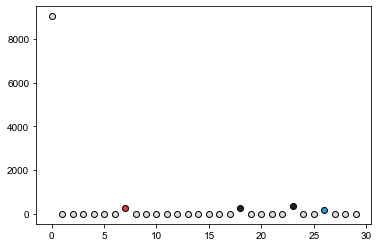

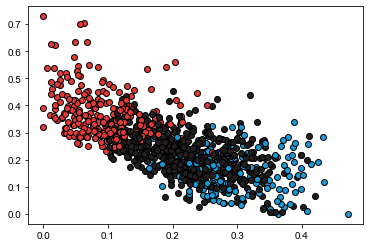

<Figure size 432x288 with 0 Axes>

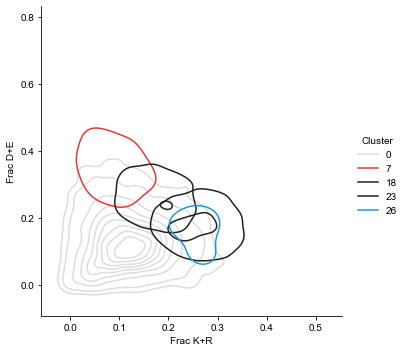

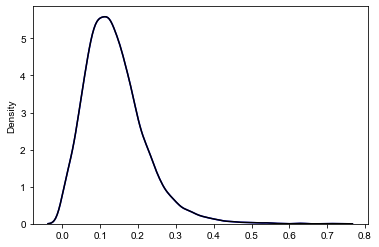

In [58]:
#colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']
colorhex=['#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#e23a36','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#dddddd','#231f20','#dddddd','#dddddd','#dddddd','#dddddd','#231f20','#dddddd','#dddddd','#189bd7','#dddddd','#dddddd','#dddddd']
colorhex2=['#dddddd','#e23a36','#231f20','#231f20','#189bd7']
#colorhex2=['#dddddd','#e23a36','#231f20','#c5b0d5','#189bd7']


ctmplist=[]
for c in range(0,len(subclustersNODIST)):
    if subclustersNODIST[c]==7 or subclustersNODIST[c]==18 or subclustersNODIST[c]==23 or subclustersNODIST[c]==26:
        ctmplist.append(subclustersNODIST[c])
    else:
        ctmplist.append(0)

dtmp=pd.DataFrame()
dtmp['Gene']=subgeneswnumsNODIST
#dtmp['Cluster']=subclustersNODIST
dtmp['Cluster']=ctmplist
dtmp['Frac K+R']=aafraclist
dtmp['Location']=sublocationbyunistringNODIST
dtmp['Frac D+E']=ncprlist

#dtmp=dtmp[dtmp['Location'].str.contains('Nuclear speckles')]
#dtmp=dtmp[dtmp['Location'].str.contains('Nucleoli')]
#dtmp=dtmp[dtmp['Location'].str.contains('Nucleoplasm')]

print(len(dtmp['Frac K+R'].tolist()))
print(dtmp.head(50))

aafraclisttmp=dtmp['Frac K+R'].tolist()
ncprlisttmp=dtmp['Frac D+E'].tolist()
clusterlisttmp=dtmp['Cluster'].tolist()
genelisttmp=dtmp['Gene'].tolist()

numclusttmp=[]
plt.figure()
for c in range(0,max(subclustersNODIST)+1):
    numclusttmp.append(clusterlisttmp.count(c))
    plt.plot(c,clusterlisttmp.count(c),'o',color=colorhex[c],markeredgecolor='#000000')
print(numclusttmp)

plt.figure()
#sbn.displot(dtmp, x="AA Frac", y="NCPR", kind="kde",cmap='Greys',shade=True, cbar=True)
#sbn.kdeplot(dtmp, x="AA Frac", y="NCPR", fill=True, cbar=True, thresh=0.02,cmap='Greys')
for i in range(0,len(aafraclisttmp)):
    if clusterlisttmp[i]==26 or clusterlisttmp[i]==18 or clusterlisttmp[i]==7 or clusterlisttmp[i]==23:
        plt.plot(aafraclisttmp[i],ncprlisttmp[i],'o',color=colorhex[clusterlisttmp[i]],markeredgecolor='#000000')
    #else:
    #    #plt.plot(aafraclisttmp[i],ncprlisttmp[i],'o',color=colorhex[clusterlisttmp[i]],markeredgecolor='#000000',alpha=0.2)
    #    plt.plot(aafraclisttmp[i],ncprlisttmp[i],'o',color='lightgrey',markeredgecolor='#000000',alpha=0.2)

    #if abs(ncprlisttmp[i])>=90:
    #    plt.text(aafraclisttmp[i],ncprlisttmp[i],genelisttmp[i])
#plt.yscale('log',base=10)
#plt.colorbar()
print(np.mean(ncprlisttmp)) 
print(np.mean(ncprlist)) 

plt.figure()
#plt.hist2d(aafraclisttmp, ncprlisttmp,bins=50,cmap='Greys')
sbn.displot(dtmp, x="Frac K+R", y="Frac D+E", hue="Cluster", kind="kde",palette=colorhex2,thresh=0.05)
#plt.savefig('Figures/2024_02/All_sapien_IDRs_gte_'+str(minidrlinkerlength)+'_and_nonlinkers_gte_'+str(minidrlength)+'_KR_vs_DE_contour.pdf', transparent=True, bbox_inches = "tight") 


plt.figure()
sbn.kdeplot(ncprlisttmp,color='b')
sbn.kdeplot(ncprlist,color='k')

In [7]:
#testg=['SRP72 IDR1','SHOC2 IDR1', 'NMT1 IDR1', 'KRCC1 IDR1', 'ZMAT1 IDR1', 'FRA10AC1 IDR2']
#testf=['pos-pos','pos-neg','R/K Ratio','K Patch']
testg=['NCOA5 IDR1','SNRNP27 IDR1','LUC7L IDR1','RSRP1 IDR1','ZRSR2 IDR2','SNRNP70 IDR2','SRRM5 IDR1','PRPF38B IDR2','CLASRP IDR2','LUC7L2 IDR1']
testf=['R Patch','Frac R','R/K Ratio','pos-pos']

for f in range(0,len(testf)):
    idx2=myfeat.index(testf[f])
    print(testf[f])
    for g in range(0,len(testg)):
        idx1=fullgeneswnums.index(testg[g])
        print(fullzvec[idx1,idx2])
    


R Patch
15.951750847743783
11.570172471383268
9.897536742648132
8.412006020542306
8.308885562589754
8.295027046018353
2.5015778899366876
5.694005048057023
4.006950045798309
9.739895702996664
Frac R
4.79755635751835
5.706698983865131
5.4909702250709795
5.0978537017340555
4.763403137176205
4.204302270834432
2.3844760984351963
3.855469930567535
2.9322730538017736
5.10451883791055
R/K Ratio
3.4174503666095
1.4526752309447482
1.674881836198916
2.3461559624135058
1.3799218296153488
2.044651633564278
0.7679961861213038
0.5247909994442758
1.1548774298610855
1.149312741150188
pos-pos
-1.8398926497823496
0.1261452326305154
-0.7044615052942536
-0.2619652751062661
-0.13498534829849668
5.211577344197836
-2.372369929194375
-1.2047494491874482
0.34490947773584313
-0.9918427753315633
